# Artificial Neural Networks and Deep Learning

---
## Homework 2: Image segmentation of Mars' stones
## Team: The Backpropagators
Arianna Procaccio, Francesco Buccoliero, Kai-Xi Matteo Chen, Luca Capoferri

ariii, frbuccoliero, kaiximatteoc, luke01

246843, 245498, 245523, 259617


## ⚙️ Import Libraries

In [68]:
#from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
#from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import albumentations as A
import numpy as np
import tensorflow as tf

# ⚙️ Settings

In [69]:
seed = 666

train_ratio = 0.85
validation_ratio = 0.10
test_ratio = 0.05

IMG_SIZE = (64, 128)
NUM_CLASSES = 5

running_on = "local" # local | colab | kaggle

quick_run = False # If true skips the early plotting stuff

model_name = 'TURKEYSEG' # U_NET | U_NET_XCEPTION | UWNet | ASPP | ROCKSEG | TURKEYSEG

# Training schedule
training_schedule = [
	# E.g. a first run over non-augmented data
	{
		"augmentation" : False,
		"epochs": 100,
		"batch_size": 16,
		"lr": 1e-4,
		"opt_name": "AdamW", # SGD | Adam | AdamW | Lion | Ranger
	},
	# Second run over augmented data
	{
		"augmentation" : True,
		"augmentation_repetition": 3,
		#"enlarge_dataset_with_custom_np_ds": True,
		"include_non_augmented": False,
		"epochs": 1000,
		"batch_size": 32,
		"lr": 3e-4,
		"opt_name": "AdamW", # SGD | Adam | AdamW | Lion | Ranger
	}
]

# Exponential decay
opt_exp_decay_rate: float | None = None 
opt_decay_epoch_delta = 7 # Number of epochs between each decay, if above None is not used

USE_CLASS_WEIGHTS = False # If true the model will use class weights to balance the dataset

loss_fn = 'sparse_categorical_crossentropy'

FREE_MODEL = False # If true the model is deleted from memory after being dumped to file

model_filename_override = None # If not None will load the model from this file and perform inference

DATASET_PATH_LOCAL = "dataset.npz"
DATASET_PATH_COLAB = "/content/drive/MyDrive/Colab Notebooks/dataset.npz"
DATASET_PATH_KAGGLE = "/kaggle/input/dataset-h2/dataset.npz"

OUTLIER_MASK_LOCAL = "outlier_mask.npy"
OUTLIER_MASK_COLAB = "/content/drive/MyDrive/Colab Notebooks/outlier_mask.npy"
OUTLIER_MASK_KAGGLE = "/kaggle/input/dataset-h2/outlier_mask.npy"

In [70]:
# Define here the Albumentation pipeline to be used for augmentation

def build_augmentation():
	transform = A.Compose([
					A.RandomRotate90(p=0.7),  # Random 90-degree rotation
					A.HorizontalFlip(p=0.7),  # Horizontal flip for diverse texture representation
					A.VerticalFlip(p=0.7),  # Vertical flip to simulate different orientations
					A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),  # Adjust brightness and contrast
					A.GaussianBlur(blur_limit=3, p=0.7),  # Add blur to simulate camera effects
					A.CoarseDropout(max_holes=4, max_height=16, max_width=16, p=0.7),  # Randomly occlude parts of the image
					A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.7),  # Random shifts, scales, and rotations
					A.ElasticTransform(alpha=1, sigma=50, p=0.7),
					A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.7),
					A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.7),
					A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], p=1),  # Resize for consistent input size
			])

	# For Matteo, do not delete
	#transform = A.Compose([
	#  A.RandomRotate90(p=0.7),  # Random 90-degree rotation
	#  A.HorizontalFlip(p=0.7),  # Horizontal flip for diverse texture representation
	#  A.VerticalFlip(p=0.7),  # Vertical flip to simulate different orientations
	#  A.ElasticTransform(alpha=50, sigma=50, p=0.7),
	#  A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.7),
	#  A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], p=1),  # Resize for consistent input size
	#])
	
	return transform

In [71]:
# A custom augmentation for some specific targets (e.g. images with a lot of background)
def build_augmentation_bg():
	transform = A.Compose([
		  A.RandomRotate90(p=0.8),  # Random 90-degree rotation
		  A.HorizontalFlip(p=0.8),  # Horizontal flip for diverse texture representation
		  A.VerticalFlip(p=0.8),  # Vertical flip to simulate different orientations
		  A.ElasticTransform(alpha=10, sigma=50, p=0.5),
		  A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
		  A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], p=1),  # Resize for consistent input size
	  ])
	return transform

In [72]:
# Loading configurations based on the given settings
assert train_ratio + validation_ratio + test_ratio == 1

np.random.seed(seed)
tf.random.set_seed(seed)

DATASET_PATH = DATASET_PATH_LOCAL if running_on == "local" else DATASET_PATH_COLAB if running_on == "colab" else DATASET_PATH_KAGGLE
OUTLIER_MASK = OUTLIER_MASK_LOCAL if running_on == "local" else OUTLIER_MASK_COLAB if running_on == "colab" else OUTLIER_MASK_KAGGLE

data = np.load(DATASET_PATH)
outlier_mask_template = np.load(OUTLIER_MASK) # discovered by hand

## ⏳ Load, inspect and prepare the data

In [73]:
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

hidden_X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test hidden X shape: {hidden_X_test.shape}")

# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255
X_train = X_train.astype(np.float32)
hidden_X_test = hidden_X_test[..., np.newaxis] / 255
hidden_X_test = hidden_X_test.astype(np.float32)

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

# Split train and validation
validation_size = int(X_train.shape[0] * validation_ratio)

indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

# Define train and validation indices
split_indices = [int(X_train.shape[0] * train_ratio), int(X_train.shape[0] * (train_ratio + validation_ratio))]

X_train, X_val, X_test = np.split(X_train, split_indices)
y_train, y_val, y_test = np.split(y_train, split_indices)

print("======= BEFORE REMOVING OUTLIERS =======")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Validation y shape: {y_val.shape}")
print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")

# Outliers share the mask
train_outliers_indices = [i for i, img in enumerate(y_train) if not np.array_equal(img, outlier_mask_template)]
val_outliers_indices = [i for i, img in enumerate(y_val) if not np.array_equal(img, outlier_mask_template)]
test_outliers_indices = [i for i, img in enumerate(y_test) if not np.array_equal(img, outlier_mask_template)]
print(f'Total outliers in train set: {y_train.shape[0] - len(train_outliers_indices)}')
print(f'Total outliers in validation set: {y_val.shape[0] - len(val_outliers_indices)}')
print(f'Total outliers in test set: {y_test.shape[0] - len(test_outliers_indices)}')

# Remove outlier from train and validation set
X_train = X_train[train_outliers_indices]
y_train = y_train[train_outliers_indices]
X_val = X_val[val_outliers_indices]
y_val = y_val[val_outliers_indices]
X_test = X_test[test_outliers_indices]
y_test = y_test[test_outliers_indices]

print("======= AFTER REMOVING OUTLIERS =======")
print(f'Updated train dataset size: {X_train.shape}')
print(f'Updated validation dataset size: {X_val.shape}')
print(f'Updated test dataset size: {X_test.shape}')

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test hidden X shape: (10022, 64, 128)
Input shape: (64, 128, 1)
Number of classes: 5
======= BEFORE REMOVING OUTLIERS =======
Training X shape: (2222, 64, 128, 1)
Training y shape: (2222, 64, 128)
Validation X shape: (262, 64, 128, 1)
Validation y shape: (262, 64, 128)
Test X shape: (131, 64, 128, 1)
Test y shape: (131, 64, 128)
Total outliers in train set: 89
Total outliers in validation set: 16
Total outliers in test set: 5
======= AFTER REMOVING OUTLIERS =======
Updated train dataset size: (2133, 64, 128, 1)
Updated validation dataset size: (246, 64, 128, 1)
Updated test dataset size: (126, 64, 128, 1)


In [74]:
# Retrieve images with a lot of label labels
def retrieve_imgs_of_label(X, y, bg_label_min_percentage=0.9, label=0):
	tot_pixels = IMG_SIZE[0] * IMG_SIZE[1]
	imgs = []
	labels = []
	# Count pixels for each class
	for label_image, img in zip(y, X):
		unique, counts = np.unique(label_image, return_counts=True)
		for u, c in zip(unique, counts):
			#print(u, c)
			#if (int(u) == 0):
			#  print('z', c)
			if int(u) == label and c / tot_pixels >= bg_label_min_percentage:
				imgs.append(img)
				labels.append(label_image)
	return np.array(imgs), np.array(labels)

bg_imgs, bg_labels = retrieve_imgs_of_label(X_train, y_train)

In [75]:
# Plot the data. The number of images being displayed are rows X cols
def plot(data, mask=None, num_images=10, rows=4, cols=8):
	# Reshape if needed (e.g., remove channel dimension for grayscale images)
	if data.shape[-1] == 1:  # Grayscale case
		data = data.squeeze(axis=-1)  # Remove channel dimension
	
	if mask is None:
		# Plot settings
		_, axes = plt.subplots(rows, cols, figsize=(12, 6))  # Adjust figure size as needed
	
		# Display images
		for i, ax in enumerate(axes.flat):
			if i < len(data):  # Check if there are enough images
				ax.imshow(data[i], cmap='gray' if len(data[i].shape) == 2 else None)
				ax.axis('off')  # Hide axes
			else:
				ax.axis('off')  # Hide any empty subplot
	
		plt.tight_layout()
		plt.show()
	else:
		num_samples = num_images  # Number of images to display
		if num_samples < 4:
			num_samples = 4

		# Plot settings
		fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 2))

		for i in range(num_samples):
			# Original image
			axes[i, 0].imshow(data[i], cmap="gray")
			axes[i, 0].set_title(f"Image {i+1}")
			axes[i, 0].axis("off")

			# Corresponding mask
			axes[i, 1].imshow(mask[i], cmap="viridis", alpha=0.8)  # Adjust cmap as needed
			axes[i, 1].set_title(f"Mask {i+1}")
			axes[i, 1].axis("off")

		plt.tight_layout()
		plt.show()

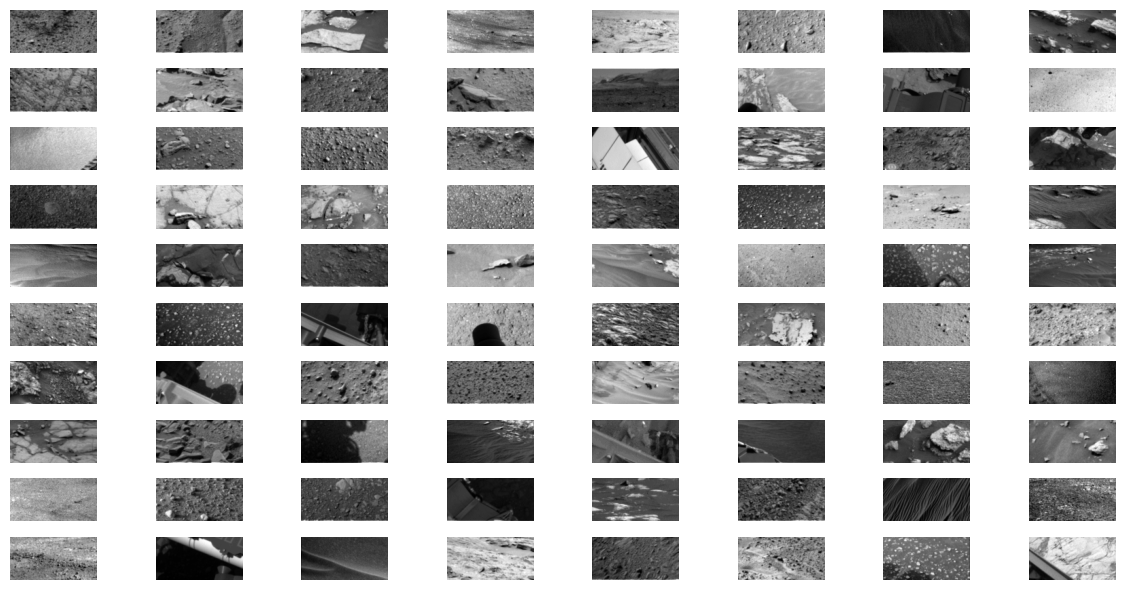

In [76]:
if not quick_run:
	plot(X_train, rows=10, cols=8)

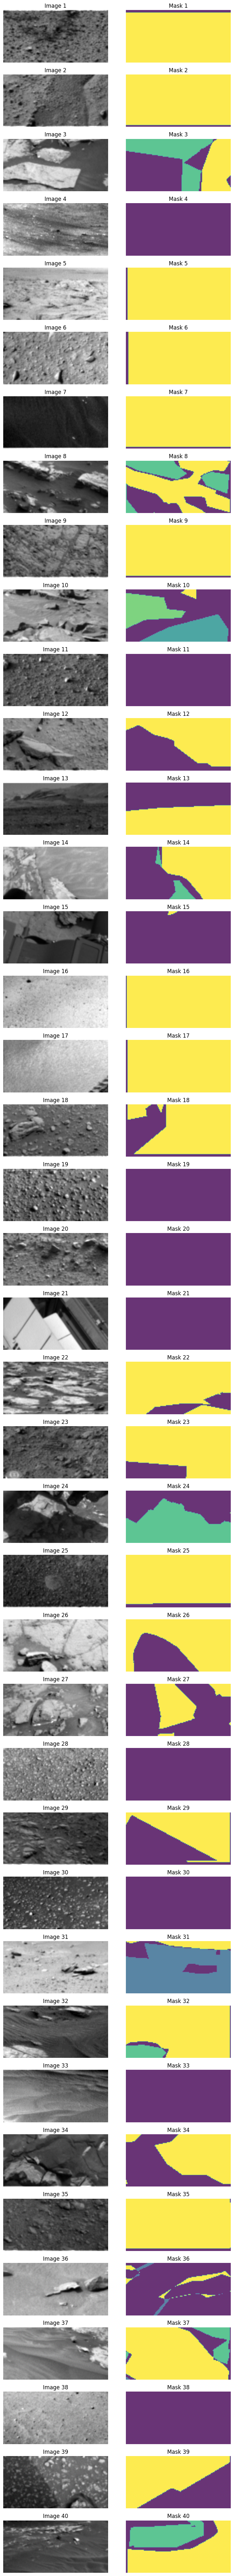

In [77]:
# An additional check: you should not see any outlier
if not quick_run:
	plot(X_train, mask=y_train, num_images=40)

Class Distribution (% of pixels):
Class 0: 24.21%
Class 1: 34.56%
Class 2: 23.05%
Class 3: 18.05%
Class 4: 0.13%


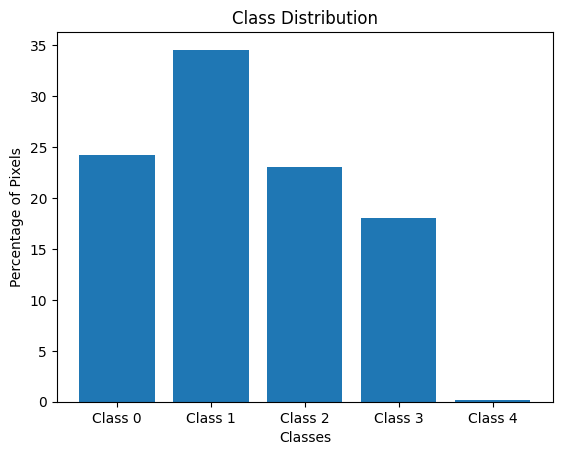

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


In [78]:
def check_class_distribution(label_dataset, num_classes):
	# Initialize counts for each class
	class_counts = np.zeros(num_classes)

	# Count pixels for each class
	for label_image in label_dataset:
			unique, counts = np.unique(label_image, return_counts=True)
			for u, c in zip(unique, counts):
					class_counts[u] += c

	# Normalize counts (percentage)
	total_pixels = np.sum(class_counts)
	class_distribution = class_counts / total_pixels * 100

	# Print and visualize
	print("Class Distribution (% of pixels):")
	for i in range(num_classes):
			print(f"Class {i}: {class_distribution[i]:.2f}%")
	
	if not quick_run:
		# Plot class distribution
		plt.bar(range(num_classes), class_distribution, tick_label=[f"Class {i}" for i in range(num_classes)])
		plt.xlabel("Classes")
		plt.ylabel("Percentage of Pixels")
		plt.title("Class Distribution")
		plt.show()
	
	return class_distribution

def get_class_weights(class_distribution):
	# Convert percentage to class probabilities
	class_probabilities = np.array(class_distribution) / 100.0

	# Calculate class weights (inverse of class probability)
	class_weights = 1.0 / class_probabilities

	# Normalize weights (optional, you can skip normalization if desired)
	max_weight = np.max(class_weights)
	class_weights = class_weights / max_weight  # Normalize to have the maximum weight = 1

	return {i:w for i,w in enumerate(class_weights)}

# Check for 5 classes (class IDs: 0-4)
class_distribution = check_class_distribution([e.astype(np.int8) for e in y_train], num_classes=num_classes)
class_weights = get_class_weights(class_distribution) if USE_CLASS_WEIGHTS else {i:1.0 for i in range(NUM_CLASSES)}
print('Class weights:', class_weights)

In [79]:
# `concat_and_shuffle_aug_with_no_aug` will double the X_train size
# `remove_bg` will set all the bg pixels to dark
# `augmentation_repetition` will concatenate n times the augmented dataset by applying the same `augmentations` fn. Useful for augmentation pipeline with probability activations
def get_dataset(X, y, batch_size=32, augmentations=None, augmentation_repetition=1, **kwargs):

	def resize_img_and_mask(img, mask):
		input_img = tf.image.resize(img, IMG_SIZE)
		input_img = tf.cast(input_img, tf.float32)

		# Resize needs at least 3 dims, add a dummy one
		if kwargs.get('one_hot', False):
			mask = tf.cast(mask, tf.int32)
			target_img = tf.one_hot(mask, depth=num_classes, axis=-1)
		else:
			target_img = tf.expand_dims(mask, axis=-1)
		# Nearest-neighbor is essential for resizing segmentation masks because it preserves the discrete class labels (e.g., 0, 1, 2) without introducing unintended values due to interpolation
		target_img = tf.image.resize(target_img, IMG_SIZE, method="nearest")
		target_img = tf.cast(target_img, tf.int32) # Consider lower integers

		return input_img, target_img

	def remove_background(image, mask, background_label=0):
		background_mask = (mask == background_label)
		image[background_mask] = 0  # Set to black
		return image, mask

	def apply_augmentation_np():
		X_a = []
		y_a = []
		for i, m in zip(X, y):
			aug_img, aug_mask = augmentations(i, m)
			if kwargs.get('remove_bg', False):
				aug_img, aug_mask = remove_background(aug_img, aug_mask)
			X_a.append(aug_img)  
			y_a.append(aug_mask)  
		return np.array(X_a), np.array(y_a)
	
	def to_one_hot(x, y):
		y_one_hot = tf.one_hot(y, depth=num_classes, axis=-1)
		return x, y_one_hot

	if kwargs.get('remove_bg', False):
		X_a = []
		y_a = []
		for i, m in zip(X, y):
			aug_img, aug_mask = remove_background(i, m)
			X_a.append(aug_img)
			y_a.append(aug_mask)
		X = np.array(X_a)
		y = np.array(y_a)

	# Apply augmentations before converting to dataset (this will be serial I think but we avoid type conversions as A works on np arrays)
	if augmentations is not None:
		X_a, y_a = apply_augmentation_np()
		dataset = tf.data.Dataset.from_tensor_slices((X_a, y_a))
		if augmentation_repetition > 1:
			for i in range(augmentation_repetition-1):
				X_a, y_a = apply_augmentation_np()
				dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices((X_a, y_a)))
		add_len = 0
		if kwargs.get('additional_ds_concat', None):
			# Optimistic
			add_len = len(kwargs['additional_ds_concat'])
			for pair in kwargs['additional_ds_concat']:
				print('concatenating additional ds')
				images, labels = pair
				images = images.astype(np.float32)
				dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices((images, labels)))
		if kwargs.get('concat_and_shuffle_aug_with_no_aug', False):
			dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices((X, y)))
			dataset = dataset.shuffle(seed=seed, buffer_size=X.shape[0] * (augmentation_repetition+1+add_len))
		else:
			dataset = dataset.shuffle(seed=seed, buffer_size=X.shape[0] * (augmentation_repetition+add_len))

	else:
		dataset = tf.data.Dataset.from_tensor_slices((X, y))

	dataset = dataset.map(resize_img_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
	dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
	return dataset

In [80]:
# Enlarge dataset containing images provided in the inputs
def get_enlarged_dataset(imgs, labels, aug_fn, repetitions=2, unbatch=True, np_ds=True):
	def apply_aug(img, mask):
		transform = aug_fn()
		transformed = transform(image=img, mask=mask)
		return transformed["image"], transformed["mask"]
	if np_ds:
		X_a = []
		y_a = []
		for i, m in zip(imgs, labels):
			aug_img, aug_mask = apply_aug(i, m)
			X_a.append(aug_img)  
			y_a.append(aug_mask)  
		return np.array(X_a), np.array(y_a)
	else:
		enlarged_bg_dataset = get_dataset(imgs, labels, augmentations=apply_aug, augmentation_repetition=repetitions)
		# We unbatch as this will be concatenated with other ds
		if unbatch:
			ds = enlarged_bg_dataset.unbatch()
		return ds

(10, 64, 128, 1) (10, 64, 128)


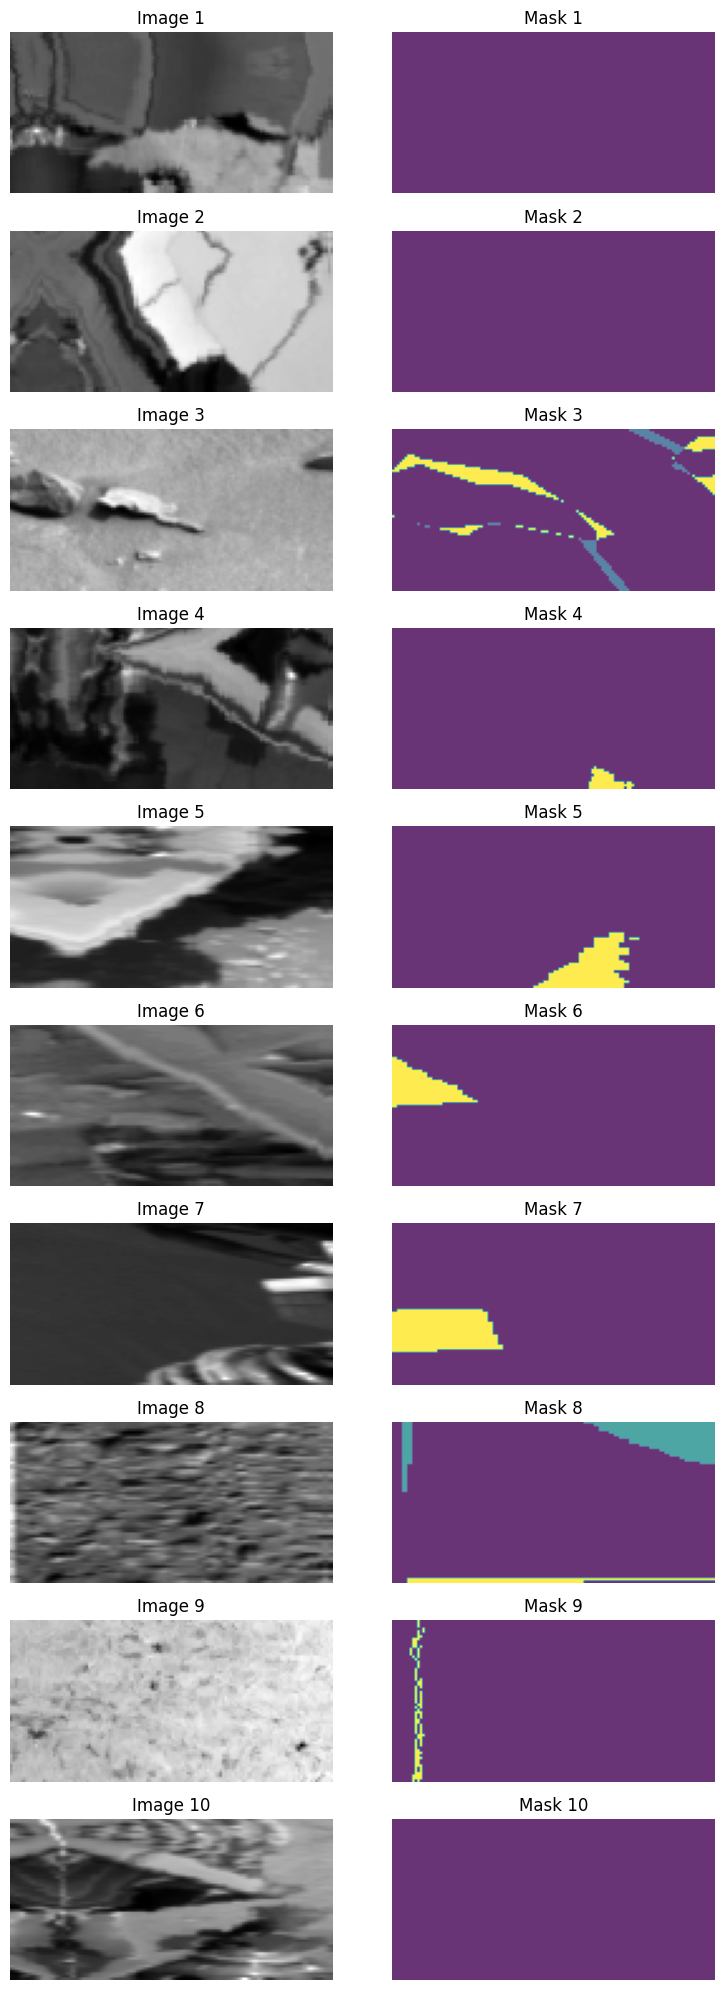

In [81]:
# Try the enlarged bg images dataset as example
if not quick_run:
	N = 10
	a, b =  get_enlarged_dataset(bg_imgs[:N], bg_labels[:N], build_augmentation_bg, np_ds=True)
	print(a.shape, b.shape)
	plot(a, mask=b, num_images=N)


## 🎲 Define training configuration

In [82]:
def dice_loss(y_true, y_pred, smooth=1e-6):
	# Convert y_true to one-hot if needed
	# TODO: should we retrieve the argmax and use 1 channels instead of 5?
	if y_true.shape[-1] != y_pred.shape[-1]:
			y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1])
	
	# Compute Dice Loss per class
	intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
	union = tf.reduce_sum(y_true + y_pred, axis=(1, 2))
	dice = (2. * intersection + smooth) / (union + smooth)
	
	# Average Dice Loss over all classes
	dice_loss = 1 - tf.reduce_mean(dice, axis=-1)
	return dice_loss

In [83]:
# Visualization callback
category_map = {
	0: 0, # Background,
	1: 1, # Soil,
	2: 2, # Bedrock,
	3: 3, # Sand,
	4: 4, # Big Rock,
}

def apply_category_mapping(label):
	"""
	Apply category mapping to labels.
	"""
	print("Label dtype before mapping:", label.dtype)
	keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
	vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
	table = tf.lookup.StaticHashTable(
		tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
		default_value=0
	)
	return table.lookup(label)

def create_segmentation_colormap(num_classes):
	"""
	Create a linear colormap using a predefined palette.
	Uses 'viridis' as default because it is perceptually uniform
	and works well for colorblindness.
	"""
	return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
	"""
	Apply the colormap to a label.
	"""
	# Ensure label is 2D
	label = np.squeeze(label)

	if colormap is None:
		num_classes = len(np.unique(label))
		colormap = create_segmentation_colormap(num_classes)

	# Apply the colormap
	colored = colormap[label.astype(int)]

	return colored
	
class VizCallback(tf.keras.callbacks.Callback):
	def __init__(self, image, label, frequency=5):
		super().__init__()
		self.image = image
		self.label = tf.cast(tf.convert_to_tensor(label), tf.int32) 
		self.frequency = frequency

	def on_epoch_end(self, epoch, logs=None):
		if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
			image, label = self.image, self.label
			label = apply_category_mapping(label)
			image = tf.expand_dims(image, 0)
			pred = self.model.predict(image, verbose=0)
			y_pred = tf.math.argmax(pred, axis=-1)
			y_pred = y_pred.numpy()

			# Create colormap
			num_classes = NUM_CLASSES
			colormap = create_segmentation_colormap(num_classes)

			plt.figure(figsize=(16, 4))

			# Input image
			plt.subplot(1, 3, 1)
			plt.imshow(image[0],cmap='gray')
			plt.title("Input Image")
			plt.axis('off')

			# Ground truth
			plt.subplot(1, 3, 2)
			colored_label = apply_colormap(label.numpy(), colormap)
			plt.imshow(colored_label)
			plt.title("Ground Truth Mask")
			plt.axis('off')

			# Prediction
			plt.subplot(1, 3, 3)
			colored_pred = apply_colormap(y_pred[0], colormap)
			plt.imshow(colored_pred)
			plt.title("Predicted Mask")
			plt.axis('off')

			plt.tight_layout()
			plt.show()
			plt.close()

In [84]:
# Define fitting callbacks. Comment out from dict the unwanted ones
val_mask = tf.expand_dims(y_val[0], axis=-1)
val_mask = tf.image.resize(val_mask, [IMG_SIZE[0], IMG_SIZE[1]], method="nearest")
val_img = tf.image.resize(X_val[0], [IMG_SIZE[0], IMG_SIZE[1]])
viz_callback = VizCallback(val_img, val_mask)
model_fit_callbacks = {
	'ReduceLROnPlateau': tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=25, min_lr=1e-6, verbose=1),
	'EarlyStopping': tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True, verbose=1),
	#'Viz_callback' : viz_callback
}

def get_callbacks():
	return [i for i in model_fit_callbacks.values()]

## 🛠️ Define model, augmentation and utils builders

In [85]:
def apply_augmentation(img, mask):
	transform = build_augmentation()
	transformed = transform(image=img, mask=mask)
	return transformed["image"], transformed["mask"]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


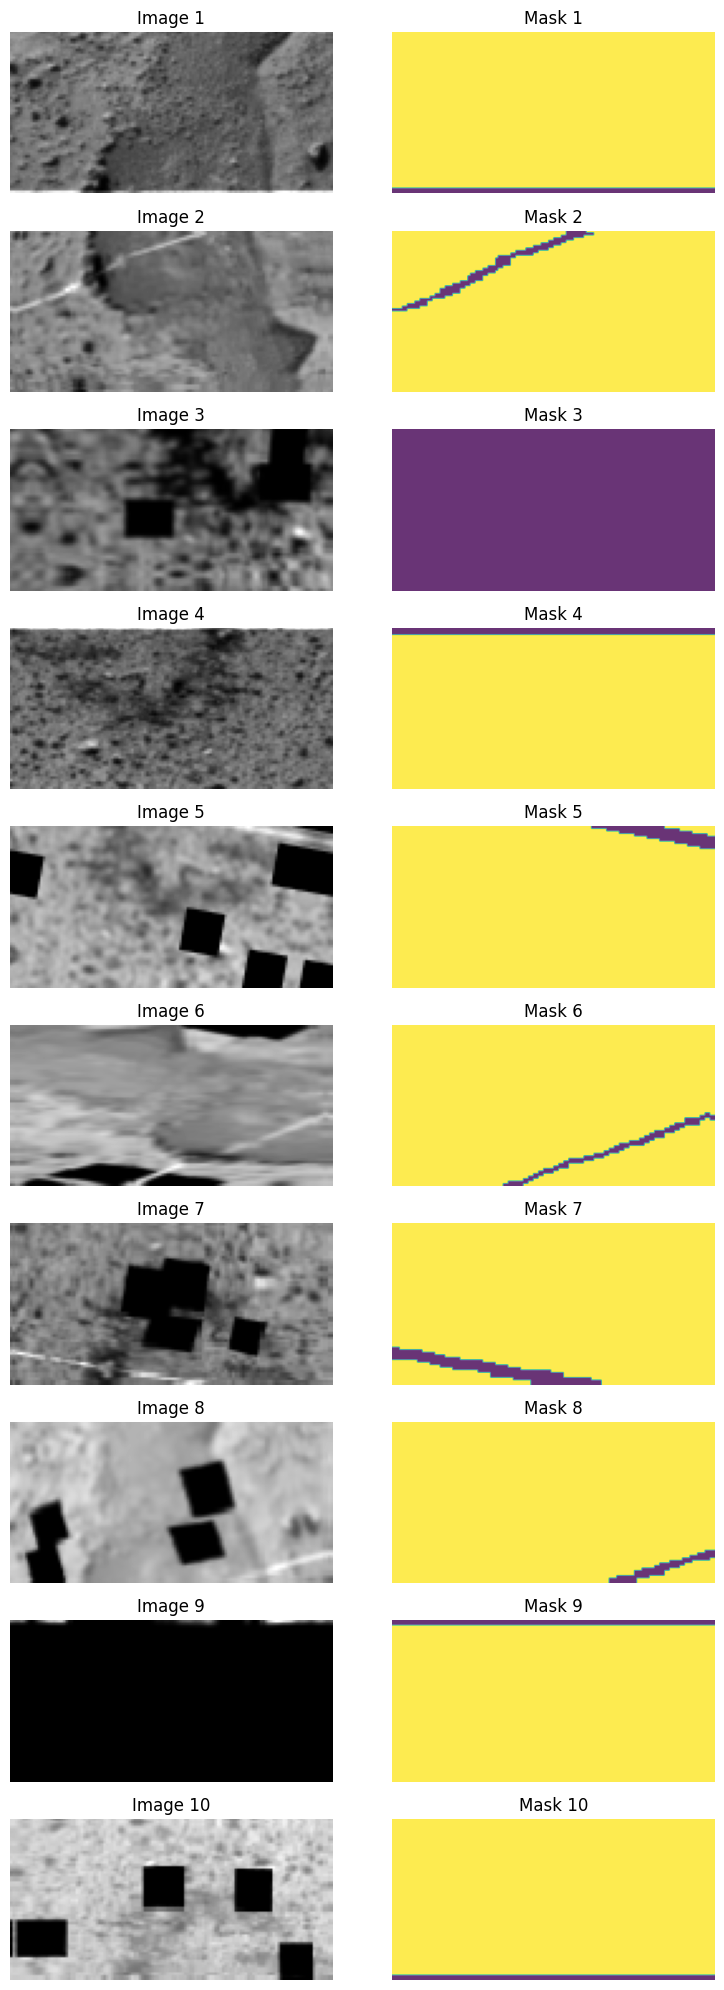

In [86]:
# Try the augmented dataset
if not quick_run:
	N = 2
	ds = get_dataset(X_train[:N], y_train[:N], augmentations=apply_augmentation, augmentation_repetition=4, concat_and_shuffle_aug_with_no_aug=True)

	for batch in ds.take(1):
		a, b = batch
		plot(a.numpy(), b.numpy(), num_images=N * 5) # use N * (augmentation_repetition+1) as `concat_and_shuffle_aug_with_no_aug` is True 
		break


In [87]:
# taken from https://keras.io/examples/vision/oxford_pets_image_segmentation/
def build_U_NET_XCEPTION(img_size: tuple[int, int, int], num_classes):
	inputs = tfk.Input(shape=img_size) # One channel input

	### [First half of the network: downsampling inputs] ###

	# Entry block
	x = tfkl.Conv2D(32, 3, strides=2, padding="same")(inputs)
	x = tfkl.BatchNormalization()(x)
	x = tfkl.Activation("relu")(x)

	previous_block_activation = x  # Set aside residual

	# Blocks 1, 2, 3 are identical apart from the feature depth.
	for filters in [64, 128, 256]:
		x = tfkl.Activation("relu")(x)
		x = tfkl.SeparableConv2D(filters, 3, padding="same")(x)
		x = tfkl.BatchNormalization()(x)

		x = tfkl.Activation("relu")(x)
		x = tfkl.SeparableConv2D(filters, 3, padding="same")(x)
		x = tfkl.BatchNormalization()(x)

		x = tfkl.MaxPooling2D(3, strides=2, padding="same")(x)

		# Project residual
		residual = tfkl.Conv2D(filters, 1, strides=2, padding="same")(
		previous_block_activation
		)
		x = tfkl.add([x, residual])  # Add back residual
		previous_block_activation = x  # Set aside next residual

	### [Second half of the network: upsampling inputs] ###

	for filters in [256, 128, 64, 32]:
		x = tfkl.Activation("relu")(x)
		x = tfkl.Conv2DTranspose(filters, 3, padding="same")(x)
		x = tfkl.BatchNormalization()(x)

		x = tfkl.Activation("relu")(x)
		x = tfkl.Conv2DTranspose(filters, 3, padding="same")(x)
		x = tfkl.BatchNormalization()(x)

		x = tfkl.UpSampling2D(2)(x)

		# Project residual
		residual = tfkl.UpSampling2D(2)(previous_block_activation)
		residual = tfkl.Conv2D(filters, 1, padding="same")(residual)
		x = tfkl.add([x, residual])  # Add back residual
		previous_block_activation = x  # Set aside next residual

	# Add a per-pixel classification layer
	outputs = tfkl.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

	# Define the model
	model = tfk.Model(inputs, outputs, name='UNetXception')
	return model

In [88]:
def build_U_NET(img_size: tuple[int, int, int], num_classes):
	def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
		# Initialise the input tensor
		x = input_tensor

		# Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
		for i in range(stack):
				x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
				x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
				x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

		# Return the transformed tensor
		return x

	input_layer = tfkl.Input(shape=img_size, name='input_layer')

	# Downsampling path
	down_block_1 = unet_block(input_layer, 32, name='down_block1_')
	d1 = tfkl.MaxPooling2D()(down_block_1)

	down_block_2 = unet_block(d1, 64, name='down_block2_')
	d2 = tfkl.MaxPooling2D()(down_block_2)

	# Bottleneck
	bottleneck = unet_block(d2, 128, name='bottleneck')

	# Upsampling path
	u1 = tfkl.UpSampling2D()(bottleneck)
	u1 = tfkl.Concatenate()([u1, down_block_2])
	u1 = unet_block(u1, 64, name='up_block1_')

	u2 = tfkl.UpSampling2D()(u1)
	u2 = tfkl.Concatenate()([u2, down_block_1])
	u2 = unet_block(u2, 32, name='up_block2_')

	# Output Layer
	output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

	model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
	return model

In [89]:
def build_ATTENTION_UW_NET(img_size: tuple[int, int, int], num_classes):
	def attention_block(x, g, inter_channel):
		# theta_x (bs, h, w, inter_channel)
		theta_x = tfkl.Conv2D(inter_channel, [1, 1], strides=[1, 1])(x)
		
		# phi_g (bs, h, w, inter_channel)
		phi_g = tfkl.Conv2D(inter_channel, [1, 1], strides=[1, 1])(g)
		
		# f (bs, h, w, 1)
		f = tfkl.Activation('relu')(tfkl.Add()([theta_x, phi_g]))
		psi_f = tfkl.Conv2D(1, [1, 1], strides=[1, 1])(f)
		
		# sigmoid_psi_f (bs, h, w, 1)
		sigmoid_psi_f = tfkl.Activation('sigmoid')(psi_f)
		
		# rate (bs, h, w, 1)
		rate = tfkl.multiply([x, sigmoid_psi_f])
		
		return rate
	
	# Input
	inputs = tfkl.Input(shape=img_size)
	
	# Encoder Path
	# Block 1
	conv1 = tfkl.Conv2D(64, 3, padding='same')(inputs)
	conv1 = tfkl.BatchNormalization()(conv1)
	conv1 = tfkl.Activation('relu')(conv1)
	conv1 = tfkl.Conv2D(64, 3, padding='same')(conv1)
	conv1 = tfkl.BatchNormalization()(conv1)
	conv1 = tfkl.Activation('relu')(conv1)
	pool1 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv1)
	
	# Block 2
	conv2 = tfkl.Conv2D(128, 3, padding='same')(pool1)
	conv2 = tfkl.BatchNormalization()(conv2)
	conv2 = tfkl.Activation('relu')(conv2)
	conv2 = tfkl.Conv2D(128, 3, padding='same')(conv2)
	conv2 = tfkl.BatchNormalization()(conv2)
	conv2 = tfkl.Activation('relu')(conv2)
	pool2 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv2)
	
	# Block 3
	conv3 = tfkl.Conv2D(256, 3, padding='same')(pool2)
	conv3 = tfkl.BatchNormalization()(conv3)
	conv3 = tfkl.Activation('relu')(conv3)
	conv3 = tfkl.Conv2D(256, 3, padding='same')(conv3)
	conv3 = tfkl.BatchNormalization()(conv3)
	conv3 = tfkl.Activation('relu')(conv3)
	pool3 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv3)
	
	# Block 4
	conv4 = tfkl.Conv2D(512, 3, padding='same')(pool3)
	conv4 = tfkl.BatchNormalization()(conv4)
	conv4 = tfkl.Activation('relu')(conv4)
	conv4 = tfkl.Conv2D(512, 3, padding='same')(conv4)
	conv4 = tfkl.BatchNormalization()(conv4)
	conv4 = tfkl.Activation('relu')(conv4)
	pool4 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv4)
	
	# Bridge
	conv5 = tfkl.Conv2D(1024, 3, padding='same')(pool4)
	conv5 = tfkl.BatchNormalization()(conv5)
	conv5 = tfkl.Activation('relu')(conv5)
	conv5 = tfkl.Conv2D(1024, 3, padding='same')(conv5)
	conv5 = tfkl.BatchNormalization()(conv5)
	conv5 = tfkl.Activation('relu')(conv5)
	
	# Decoder Path with Attention
	# Block 6
	up6 = tfkl.Conv2D(512, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv5))
	up6 = tfkl.BatchNormalization()(up6)
	up6 = tfkl.Activation('relu')(up6)
	
	att6 = attention_block(conv4, up6, inter_channel=256)
	merge6 = tfkl.concatenate([att6, up6], axis=3)
	
	conv6 = tfkl.Conv2D(512, 3, padding='same')(merge6)
	conv6 = tfkl.BatchNormalization()(conv6)
	conv6 = tfkl.Activation('relu')(conv6)
	conv6 = tfkl.Conv2D(512, 3, padding='same')(conv6)
	conv6 = tfkl.BatchNormalization()(conv6)
	conv6 = tfkl.Activation('relu')(conv6)
	
	# Block 7
	up7 = tfkl.Conv2D(256, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv6))
	up7 = tfkl.BatchNormalization()(up7)
	up7 = tfkl.Activation('relu')(up7)
	
	att7 = attention_block(conv3, up7, inter_channel=128)
	merge7 = tfkl.concatenate([att7, up7], axis=3)
	
	conv7 = tfkl.Conv2D(256, 3, padding='same')(merge7)
	conv7 = tfkl.BatchNormalization()(conv7)
	conv7 = tfkl.Activation('relu')(conv7)
	conv7 = tfkl.Conv2D(256, 3, padding='same')(conv7)
	conv7 = tfkl.BatchNormalization()(conv7)
	conv7 = tfkl.Activation('relu')(conv7)
	
	# Block 8
	up8 = tfkl.Conv2D(128, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv7))
	up8 = tfkl.BatchNormalization()(up8)
	up8 = tfkl.Activation('relu')(up8)
	
	att8 = attention_block(conv2, up8, inter_channel=64)
	merge8 = tfkl.concatenate([att8, up8], axis=3)
	
	conv8 = tfkl.Conv2D(128, 3, padding='same')(merge8)
	conv8 = tfkl.BatchNormalization()(conv8)
	conv8 = tfkl.Activation('relu')(conv8)
	conv8 = tfkl.Conv2D(128, 3, padding='same')(conv8)
	conv8 = tfkl.BatchNormalization()(conv8)
	conv8 = tfkl.Activation('relu')(conv8)
	
	# Block 9
	up9 = tfkl.Conv2D(64, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv8))
	up9 = tfkl.BatchNormalization()(up9)
	up9 = tfkl.Activation('relu')(up9)
	
	att9 = attention_block(conv1, up9, inter_channel=32)
	merge9 = tfkl.concatenate([att9, up9], axis=3)
	
	conv9 = tfkl.Conv2D(64, 3, padding='same')(merge9)
	conv9 = tfkl.BatchNormalization()(conv9)
	conv9 = tfkl.Activation('relu')(conv9)
	conv9 = tfkl.Conv2D(64, 3, padding='same')(conv9)
	conv9 = tfkl.BatchNormalization()(conv9)
	conv9 = tfkl.Activation('relu')(conv9)
	
	# Output
	outputs = tfkl.Conv2D(num_classes, 1, activation='softmax')(conv9)
	
	model = tfk.Model(inputs=inputs, outputs=outputs, name='AttentionUWNet')
	return model

In [90]:
def build_ASPP_model(img_size: tuple[int, int, int], num_classes: int):
	
	initializer = tf.keras.initializers.HeNormal()
	regularizer = tf.keras.regularizers.l2(1e-4)

	inputs = tfkl.Input(shape=img_size)

	def conv_block(x, filters, kernel_size=(3, 3), activation="relu", batch_norm=True, dropout_rate=0.2):
		x = tfkl.Conv2D(
			filters,
			kernel_size,
			padding="same",
			kernel_initializer=initializer,
			kernel_regularizer=regularizer,
		)(x)
		if batch_norm:
			x = tfkl.BatchNormalization()(x)
		x = tfkl.Activation(activation)(x)
		if dropout_rate > 0:
			x = tfkl.SpatialDropout2D(dropout_rate)(x)
		return x

	def encoder_block(x, filters, dropout_rate=0.2):
		x = conv_block(x, filters, dropout_rate=dropout_rate)
		x = conv_block(x, filters, dropout_rate=dropout_rate)
		p = tfkl.MaxPooling2D(2)(x)
		return x, p

	def atrous_spatial_pyramid_pooling(x, dropout_rate=0.3):
		dims = x.shape[1:3]
		pool = tfkl.GlobalAveragePooling2D()(x)
		pool = tfkl.Reshape((1, 1, x.shape[-1]))(pool)
		pool = tfkl.Conv2D(
			256, 
			1, 
			padding="same", 
			kernel_initializer=initializer, 
			kernel_regularizer=regularizer,
		)(pool)
		pool = tfkl.UpSampling2D(size=dims, interpolation="bilinear")(pool)
		pool = tfkl.SpatialDropout2D(dropout_rate)(pool)

		conv_1x1 = tfkl.Conv2D(
			256,
			1,
			padding="same",
			kernel_initializer=initializer,
			kernel_regularizer=regularizer,
		)(x)
		atrous_6 = tfkl.Conv2D(
			256,
			3,
			dilation_rate=6,
			padding="same",
			kernel_initializer=initializer,
			kernel_regularizer=regularizer,
		)(x)
		atrous_12 = tfkl.Conv2D(
			256,
			3,
			dilation_rate=12,
			padding="same",
			kernel_initializer=initializer,
			kernel_regularizer=regularizer,
		)(x)
		atrous_18 = tfkl.Conv2D(
			256,
			3,
			dilation_rate=18,
			padding="same",
			kernel_initializer=initializer,
			kernel_regularizer=regularizer,
		)(x)

		x = tfkl.Concatenate()([pool, conv_1x1, atrous_6, atrous_12, atrous_18])
		x = tfkl.Conv2D(
			256,
			1,
			padding="same",
			kernel_initializer=initializer,
			kernel_regularizer=regularizer,
		)(x)
		x = tfkl.SpatialDropout2D(dropout_rate)(x)
		return x

	def decoder_block(x, skip, filters, dropout_rate=0.2):
		x = tfkl.Conv2DTranspose(
			filters,
			2,
			strides=2,
			padding="same",
			kernel_initializer=initializer,
			kernel_regularizer=regularizer,
		)(x)
		x = tfkl.Concatenate()([x, skip])
		x = conv_block(x, filters, dropout_rate=dropout_rate)
		return x

	# Encoder
	filters = [64, 128, 256, 512]
	skips = []
	x = inputs
	for f in filters:
		skip, x = encoder_block(x, f, dropout_rate=0.2)
		skips.append(skip)

	# Bottleneck with ASPP
	x = conv_block(x, 1024, dropout_rate=0.3)
	x = atrous_spatial_pyramid_pooling(x, dropout_rate=0.3)

	# Decoder
	skips = skips[::-1]
	decoder_filters = [512, 256, 128, 64]
	for skip, f in zip(skips, decoder_filters):
		x = decoder_block(x, skip, f, dropout_rate=0.2)

	# Final convolutional layer
	outputs = tfkl.Conv2D(
		num_classes, 
		1, 
		activation="softmax", 
		kernel_initializer=initializer, 
		kernel_regularizer=regularizer,
	)(x)

	model = tf.keras.Model(inputs, outputs)
	return model

In [91]:
def build_RockSeg(img_size: tuple[int, int, int], num_classes: int):
	"""
	Builds the RockSeg model, adjusted for input image size 64x128.

	Parameters:
		img_size (tuple): Input image dimensions (height, width, channels).
		num_classes (int): Number of output classes.

	Returns:
		tf.keras.Model: RockSeg model instance.
	"""

	initializer = tf.keras.initializers.HeNormal()
	regularizer = tf.keras.regularizers.l2(1e-4)  # L2 regularization with strength 1e-4

	def resnet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
		x = input_tensor
		for i in range(stack):
			x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_initializer=initializer,kernel_regularizer=regularizer, name=name + f'conv{i + 1}')(x)
			x = tfkl.BatchNormalization(name=name + f'bn{i + 1}')(x)
			x = tfkl.Activation(activation, name=name + f'activation{i + 1}')(x)
		return x

	def transformer_block(input_tensor, embed_dim, num_heads, name=''):
		x = tfkl.Conv2D(filters=256, kernel_size=(1, 1), padding='same', kernel_initializer=initializer,kernel_regularizer=regularizer, name=name + 'transformer_11')(input_tensor)
		x = tfkl.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="same", name=name + 'avg_pool')(x)
		x = tf.keras.tfkl.LayerNormalization(name=name + 'ln')(x)
		attention_output = tf.keras.tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=name + 'mha')(x, x)
		x = tf.keras.tfkl.Add(name=name + 'skip1')([x, attention_output])
		feed_forward = tfkl.Dense(embed_dim, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer, name=name + 'dense')(x)
		x = tf.keras.tfkl.Add(name=name + 'skip2')([x, feed_forward])
		return x

	def multiscale_feature_fusion(feature_maps, name=''):
		base_channels = feature_maps[len(feature_maps) // 2].shape[-1]
		consistent_features = [
			tfkl.Conv2D(base_channels, kernel_size=(1, 1), padding='same', kernel_initializer=initializer,kernel_regularizer=regularizer, name=name + f'conv_{i}')(fm) if fm.shape[-1] != base_channels else fm
			for i, fm in enumerate(feature_maps)
		]
		base_height, base_width = consistent_features[len(consistent_features) // 2].shape[1:3]
		resized_features = [
			tfkl.UpSampling2D(size=(base_height // fm.shape[1], base_width // fm.shape[2]), interpolation='bilinear', name=name + f'up_{i}')(fm)
			if fm.shape[1] < base_height else
			tfkl.MaxPooling2D(pool_size=(fm.shape[1] // base_height, fm.shape[2] // base_width), name=name + f'pool_{i}')(fm)
			for i, fm in enumerate(consistent_features)
		]
		fused = tfkl.Concatenate(name=name + 'concat')(resized_features)
		return tfkl.Conv2D(base_channels, kernel_size=1, padding='same', activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer, name=name + 'conv_fused')(fused)

	input_layer = tfkl.Input(shape=img_size, name='input_layer')

	conv1 = tfkl.Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer,kernel_regularizer=regularizer, name='conv1')(input_layer)
	conv1_upsampled = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear', name='conv1_upsampled')(conv1)
	maxpool1 = tfkl.MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

	resnet1 = resnet_block(maxpool1, filters=64, stack=2, name='resnet1_')
	resnet2 = resnet_block(resnet1, filters=128, stack=2, name='resnet2_')

	transformer = transformer_block(resnet2, embed_dim=256, num_heads=4, name='transformer_')

	bottleneck = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer, name='bottleneck')(transformer)

	msf1 = multiscale_feature_fusion([resnet1, resnet2, bottleneck], name='msf1_')
	msf1_upsampled = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear', name='msf1_upsample')(msf1)

	resnet1_upsampled = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear', name='resnet1_upsample')(resnet1)

	concat1 = tfkl.Concatenate(name='concat1')([msf1_upsampled, resnet1_upsampled])
	decoder1 = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer, name='decoder1')(concat1)

	upsample2 = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear', name='upsample2')(decoder1)

	concat2 = tfkl.Concatenate(name='concat2')([upsample2, conv1_upsampled])
	decoder2 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer, name='decoder2')(concat2)

	upsample3 = tfkl.UpSampling2D(size=(1, 1), interpolation='bilinear', name='upsample3')(decoder2)

	output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", kernel_initializer=initializer, name='output_layer')(upsample3)

	model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='RockSeg')

	return model

In [92]:
def build_TURKEYSEG(img_size: tuple[int, int, int], num_classes: int):
	def conv_block(inputs, filters, kernel_size=3, dilation_rate=1, use_se=True, name="conv_block"):
		"""A convolutional block with optional squeeze-and-excitation."""
		x = tfkl.Conv2D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, activation='relu', name=f"{name}_conv1")(inputs)
		x = tfkl.Conv2D(filters, kernel_size, padding='same', activation='relu', name=f"{name}_conv2")(x)
		if use_se:
			se = tfkl.GlobalAveragePooling2D(name=f"{name}_se_pool")(x)
			se = tfkl.Dense(filters // 16, activation='relu', name=f"{name}_se_dense1")(se)
			se = tfkl.Dense(filters, activation='sigmoid', name=f"{name}_se_dense2")(se)
			se = tfkl.Reshape((1, 1, filters), name=f"{name}_se_reshape")(se)
			x = tfkl.multiply([x, se], name=f"{name}_se_mult")
		return x

	def down_block(inputs, filters, name="down_block"):
		"""Downsampling block with max pooling."""
		x = conv_block(inputs, filters, name=f"{name}_conv")
		p = tfkl.MaxPooling2D(pool_size=(2, 2), name=f"{name}_pool")(x)
		return x, p

	def up_block(inputs, skip, filters, name="up_block"):
		"""Upsampling block with skip connections."""
		x = tfkl.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', name=f"{name}_upsample")(inputs)
		x = tfkl.concatenate([x, skip], name=f"{name}_concat")
		x = conv_block(x, filters, name=f"{name}_conv")
		return x

	def bottleneck_with_attention(inputs, filters, name="bottleneck"):
		"""Bottleneck with parallel dilated convolutions and MultiHeadAttention."""
		# Parallel dilated convolutions
		d1 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=1, padding='same', activation='relu', name=f"{name}_dil1")(inputs)
		d2 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=2, padding='same', activation='relu', name=f"{name}_dil2")(inputs)
		d3 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=4, padding='same', activation='relu', name=f"{name}_dil3")(inputs)
		fused = tfkl.Add(name=f"{name}_fused")([d1, d2, d3])
		
		# Reshape for attention
		b, h, w, c = fused.shape  # Batch, Height, Width, Channels
		reshaped = tfkl.Reshape((h * w, c), name=f"{name}_reshape")(fused)
		
		# MultiHeadAttention
		attention_output = tfkl.MultiHeadAttention(num_heads=4, key_dim=c, name=f"{name}_mha")(reshaped, reshaped)
		attention_output = tfkl.Reshape((h, w, c), name=f"{name}_attention_reshape")(attention_output)
		
		# Merge attention with fused features
		output = tfkl.Add(name=f"{name}_attention_fusion")([fused, attention_output])
		
		return output

	inputs = tf.keras.Input(shape=img_size, name="input_image")

	# Encoder (global context path)
	g1, p1 = down_block(inputs, 64, name="global_down1")
	g2, p2 = down_block(p1, 128, name="global_down2")
	g3, p3 = down_block(p2, 256, name="global_down3")

	# Bottleneck (global context)
	g_bottleneck = bottleneck_with_attention(p3, 512, name="global_bottleneck")

	# Decoder (global context path)
	g_up3 = up_block(g_bottleneck, g3, 256, name="global_up3")
	g_up2 = up_block(g_up3, g2, 128, name="global_up2")
	g_up1 = up_block(g_up2, g1, 64, name="global_up1")

	# Local path (for fine details)
	l1, lp1 = down_block(inputs, 32, name="local_down1")
	l2, lp2 = down_block(lp1, 64, name="local_down2")
	l_bottleneck = bottleneck_with_attention(lp2, 128, name="local_bottleneck")
	l_up2 = up_block(l_bottleneck, l2, 64, name="local_up2")
	l_up1 = up_block(l_up2, l1, 32, name="local_up1")

	# Fusion of global and local paths
	fusion = tfkl.concatenate([g_up1, l_up1], name="fusion_concat")
	fusion = conv_block(fusion, 64, name="fusion_conv")

	# Output layer
	outputs = tfkl.Conv2D(num_classes, kernel_size=1, activation='softmax', name="output_layer")(fusion)

	return tfk.Model(inputs, outputs, name="MarsSegmentationModel")

In [93]:
model_dict = {
	'U_NET': build_U_NET,
	'U_NET_XCEPTION': build_U_NET_XCEPTION,
	'UWNet': build_ATTENTION_UW_NET,
	'ASPP' : build_ASPP_model,
	'ROCKSEG' : build_RockSeg,
	'TURKEYSEG' : build_TURKEYSEG
}

In [94]:
def fit_model(model, data_loader=None, epochs=100, validation_data_loader=None):
	assert(data_loader is not None)
	assert(validation_data_loader is not None)
	fit_history = model.fit(
				data_loader,
				epochs=epochs,
				validation_data=validation_data_loader,
				class_weight=class_weights,
				callbacks=get_callbacks()
			).history
	return fit_history

In [ ]:
# Taken from https://github.com/SeanSdahl/RangerOptimizerTensorflow/blob/master/module.py
def build_ranger(lr=1e-3, weight_decay=0.0):
	try:
		import tensorflow_addons as tfa
	except:
		raise Exception("You have to install tensorflow_addons package for Ranger. Please note that this package is available up to tensorflow==2.14")
	def ranger(sync_period=6,
			slow_step_size=0.5,
			learning_rate=lr,
			beta_1=0.9,
			beta_2=0.999,
			epsilon=1e-7,
			weight_decay=weight_decay,
			amsgrad=False,
			sma_threshold=5.0,
			total_steps=0,
			warmup_proportion=0.1,
			min_lr=0.,
			name="Ranger"):
		inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
		optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
		return optim
	return ranger()

def get_optimizer(opt, batch_size, lr, **kwargs):
	decay = opt_exp_decay_rate
	if opt == "SGD":
		optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9 if 'momentum' not in kwargs else kwargs['momentum'])
		if decay is not None:
			lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
					initial_learning_rate= lr,
					decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
					decay_rate=opt_exp_decay_rate,
					staircase=True
			)
			optimizer.learning_rate = lr_schedule
			print(f'Using {opt} optimizer with exp decay {decay} (momentum = {optimizer.momentum})')
			return optimizer
		else:
			optimizer.learning_rate = lr
			print(f'Using {opt} optimizer (momentum = {optimizer.momentum})')
			return optimizer

	elif opt == "Adam":
		if 'weight_decay' in kwargs:
			optimizer = tf.keras.optimizers.Adam(weight_decay=kwargs['weight_decay'])
		else:
			optimizer = tf.keras.optimizers.Adam()
		if decay is not None:
			lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
					initial_learning_rate=lr,
					decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
					decay_rate=opt_exp_decay_rate,
					staircase=True
			)
			optimizer.learning_rate = lr_schedule
			print(f'Using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}')
			return optimizer
		else:
			optimizer.learning_rate = lr
			print(f'Using {opt} optimizer (weight decay = {optimizer.weight_decay})')
			return optimizer

	elif opt == "AdamW":
		if 'weight_decay' in kwargs:
			optimizer = tf.keras.optimizers.AdamW(weight_decay=kwargs['weight_decay'])
		else:
			optimizer = tf.keras.optimizers.AdamW()
		if decay is not None:
			lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
					initial_learning_rate= lr,
					decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
					decay_rate=opt_exp_decay_rate,
					staircase=True
			)
			optimizer.learning_rate = lr_schedule
			print(f'Using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}')
			return optimizer
		else:
			optimizer.learning_rate = lr
			print(f'Using {opt} optimizer (weight decay = {optimizer.weight_decay})')
			return optimizer

	elif opt == "Lion":
		if 'weight_decay' in kwargs:
			optimizer = tf.keras.optimizers.Lion(weight_decay=kwargs['weight_decay'])
		else:
			optimizer = tf.keras.optimizers.Lion()
		if decay is not None:
			lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
					initial_learning_rate= lr,
					decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
					decay_rate=opt_exp_decay_rate,
					staircase=True
			)
			optimizer.learning_rate = lr_schedule
			print(f'Using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}')
			return optimizer
		else:
			optimizer.learning_rate = lr
			print(f'Using {opt} optimizer (weight decay = {optimizer.weight_decay})')
			return optimizer
	elif opt == "Ranger":
		optimizer = build_ranger(lr=lr, weight_decay=0.0 if 'weight_decay' not in kwargs else kwargs['weight_decay'])
		if decay is not None:
			raise RuntimeError("Not supported")
		else:
			optimizer.learning_rate = lr
			print(f'Uusing {opt} optimizer')
			return optimizer
	print(f"Starting learning rate: {lr} and batch size: {batch_size}")

IndentationError: expected an indented block after function definition on line 7 (2686753170.py, line 20)

In [ ]:
def display_model(model):
	if not quick_run:
		# Display a summary of the model architecture
		model.summary(expand_nested=True)
		# Display model architecture with layer shapes and trainable parameters
		tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)
	else:
		# Just print the total parameters
		print(f"Total parameters: {model.count_params()/1e6:.2f}M")

## 🍣 Define and display model

In [ ]:
# Define custom Mean Intersection Over Union metric: the competition excludes the background class
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
	def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
		super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
		if labels_to_exclude is None:
			labels_to_exclude = [0]  # Default to excluding label 0
		self.labels_to_exclude = labels_to_exclude

	def update_state(self, y_true, y_pred, sample_weight=None):
		# Convert predictions to class labels
		y_pred = tf.math.argmax(y_pred, axis=-1)

		# Flatten the tensors
		y_true = tf.reshape(y_true, [-1])
		y_pred = tf.reshape(y_pred, [-1])

		# Apply mask to exclude specified labels
		for label in self.labels_to_exclude:
			mask = tf.not_equal(y_true, label)
			y_true = tf.boolean_mask(y_true, mask)
			y_pred = tf.boolean_mask(y_pred, mask)

		# Update the state
		return super().update_state(y_true, y_pred, sample_weight)

## 🧗🏻‍♂️ Train and save

In [ ]:
if not model_filename_override:
	model = model_dict[model_name](IMG_SIZE + (1,), NUM_CLASSES)
	miou = MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])

	histories = []

	for ts in training_schedule:
		model.compile(loss=loss_fn,
									optimizer=get_optimizer(batch_size=ts['batch_size'], lr = ts['lr'], opt=ts['opt_name']), 
									metrics=['accuracy', miou])
		display_model(model)
		val_data_loader = get_dataset(X_val, y_val, batch_size=ts['batch_size'])
		if ts['augmentation']:
			if ts.get('enlarge_dataset_with_custom_np_ds', False):
				# This example enlarges the images with a lot of bg labels (>=90%)
				bg_augmented_data = get_enlarged_dataset(bg_imgs, bg_labels, build_augmentation_bg)
				# You can add additional data and then using additional_ds_concat=[bg_augmented_data, ...]
				data_loader = get_dataset(X_train, y_train, 
																	batch_size=ts['batch_size'], 
																	augmentations=apply_augmentation,
																	augmentation_repetition=ts['augmentation_repetition'], 
																	concat_and_shuffle_aug_with_no_aug=ts['include_non_augmented'], additional_ds_concat=[bg_augmented_data])
				print(f"Training with augmentation x{ts['augmentation_repetition']}, enlarge_dataset_with_custom_np_ds and {'none ' if not ts['include_non_augmented'] else ''}non-augmented data.")
			else:
				data_loader = get_dataset(X_train, y_train, 
																	batch_size=ts['batch_size'], 
																	augmentations=apply_augmentation,
																	augmentation_repetition=ts['augmentation_repetition'], 
																	concat_and_shuffle_aug_with_no_aug=ts['include_non_augmented'])
				print(f"Training with augmentation x{ts['augmentation_repetition']} and {'none ' if not ts['include_non_augmented'] else ''}non-augmented data.")
		else:
			data_loader = get_dataset(X_train, y_train, batch_size=ts['batch_size'])
			print(f'Fitting model without augmentation')
		fit_history = fit_model(model, 
														data_loader=data_loader, 
														validation_data_loader=val_data_loader,
														epochs = ts['epochs'])
		histories.append(fit_history)

	# Calculate and print the final validation accuracy
	final_val_meanIoU = round(max(histories[-1]['val_mean_iou'])* 100, 2)
	print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

	# Save intermediate model
	model_filename = f'{model_name}-{str(final_val_meanIoU)}-{datetime.now().strftime("%y%m%d_%H%M")}.keras'
	model.save(model_filename)

	# Free memory by deleting the model instance
	if FREE_MODEL:
		del model

In [ ]:
def plot_training(fit):
	# Plot and display training and validation loss
	plt.figure(figsize=(18, 3))
	plt.plot(fit['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
	plt.plot(fit['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
	plt.title('Cross Entropy')
	plt.legend()
	plt.grid(alpha=0.3)
	plt.show()

	# Plot and display training and validation accuracy
	plt.figure(figsize=(18, 3))
	plt.plot(fit['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
	plt.plot(fit['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
	plt.title('Accuracy')
	plt.legend()
	plt.grid(alpha=0.3)
	plt.show()

	# Plot and display training and validation mean IoU
	plt.figure(figsize=(18, 3))
	plt.plot(fit['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
	plt.plot(fit['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
	plt.title('Mean Intersection over Union')
	plt.legend()
	plt.grid(alpha=0.3)
	plt.show()

In [ ]:
if not model_filename_override:
	for fit_history in histories:
		plot_training(fit_history)

## ✍🏿 Make prediction on test set

In [ ]:
test_dataset = get_dataset(X_test, y_test, batch_size=8)

if model_filename_override:
	model = tfk.models.load_model(model_filename_override, compile=False)
	model.compile(
		loss=loss_fn,
		optimizer=get_optimizer(),
		metrics=["accuracy", miou]
	)
	display_model(model)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=1)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

In [ ]:
def create_segmentation_colormap(num_classes):
	"""
	Create a linear colormap using a predefined palette.
	Uses 'viridis' as default because it is perceptually uniform
	and works well for colorblindness.
	"""
	return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
	"""
	Apply the colormap to a label.
	"""
	# Ensure label is 2D
	label = np.squeeze(label)

	if colormap is None:
		num_classes = len(np.unique(label))
		colormap = create_segmentation_colormap(num_classes)

	# Apply the colormap
	colored = colormap[label.astype(int)]

	return colored

def plot_triptychs(dataset, model, num_samples=1):
	"""
	Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

	Parameters:
	dataset: tf.data.Dataset - The dataset containing image-label pairs
	model: tf.keras.Model - The trained model to generate predictions
	num_samples: int - Number of samples to plot
	"""
	# Take samples from the dataset
	samples = dataset.take(num_samples)

	for images, labels in samples:
		# If we have a batch, take the first example
		if len(images.shape) == 4:  # Batch of images
			images = images[0:1]
			labels = labels[0:1]

		# Generate predictions
		pred = model.predict(images, verbose=0)
		pred = tf.math.argmax(pred, axis=-1)

		# Create colormap based on number of classes in labels
		labels_np = labels.numpy()
		num_classes = len(np.unique(labels_np))
		colormap = create_segmentation_colormap(num_classes)

		# Create figure with subplots
		fig, axes = plt.subplots(1, 3, figsize=(20, 4))

		# Plot original image
		axes[0].set_title("Original Image")
		axes[0].imshow(images[0])
		axes[0].axis('off')

		# Plot original mask
		axes[1].set_title("Original Mask")
		colored_label = apply_colormap(labels[0], colormap)
		axes[1].imshow(colored_label)
		axes[1].axis('off')

		# Plot predicted mask
		axes[2].set_title("Predicted Mask")
		colored_pred = apply_colormap(pred[0], colormap)
		axes[2].imshow(colored_pred)
		axes[2].axis('off')

		plt.tight_layout()
		plt.show()
		plt.close()

#plot_triptychs(test_dataset, model, num_samples=2)


## 🎰 Make prediction on competition test set and create csv

We are not loading the model but using the python env model as there is a current error on the `MeanIntersectionOverUnion` class which is not serializable making the model not loadable

In [ ]:
import pandas as pd

print(hidden_X_test.shape)
preds = model.predict(hidden_X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

def y_to_df(y) -> pd.DataFrame:
	"""Converts segmentation predictions into a DataFrame format for Kaggle."""
	n_samples = len(y)
	y_flat = y.reshape(n_samples, -1)
	df = pd.DataFrame(y_flat)
	df["id"] = np.arange(n_samples)
	cols = ["id"] + [col for col in df.columns if col != "id"]
	return df[cols]

submission_filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M")}.csv'
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
print('Submission saved in', submission_filename)